## Image segmentation test

In [1]:
import sys
import cv2
import time
import colorsys
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [49]:
model = tf.keras.models.load_model('../models/UCB300/128x128_acc_0.9549_loss_0.0886_val-acc_0.9554_val-loss_0.0873_0.22M_01-08-21-DB_UCB300_E_10x1E-4_5x1E-5/')

In [50]:
sys.executable

'/home/israel/repos/venvs/oak-gen2/bin/python3'

In [51]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 64, 64, 16)   432         input_2[0][0]                    
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 32, 32, 32)   4672        sequential_7[0][0]               
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 16, 16, 64)   18560       sequential_8[0][0]               
____________________________________________________________________________________________

In [52]:
def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    return colors


def apply_mask(image, mask, color, alpha=0.5):
#     if image.shape[:2] != mask.shape:
#         h, w, _ = image.shape
#         mask = cv2.resize(mask, (w, h), cv2.INTER_LINEAR)
    """Apply the given mask to the image"""
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def colorCast(img):
    ''' Takes a raw image as input and reduces the saturation of GREEN channel'''
    rng = np.array([0, 32, 64, 96, 128, 160, 192, 224, 255])
    norm_rng = rng / (2000 /(1 + 5))
    exprng = np.exp(norm_rng)
    exprng = 255 * ((exprng - exprng.max()) / (exprng.max() - exprng.min()) + 1)
    # Create a LookUp Table
    fullRange = np.arange(0, 256)
    gLUT = np.interp(fullRange, rng, exprng)

    # Get the green channel and apply the mapping
    gChannel = img[:, :, 1]
    gChannel = cv2.LUT(gChannel, gLUT)
    img[:, :, 1] = gChannel
    return img

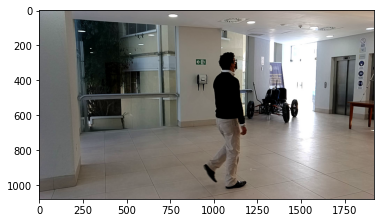

In [53]:
clip_path = '/home/israel/Downloads/OAKD_8S/clips/120/000/nm/nm-06.avi'
cap = cv2.VideoCapture(clip_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 40)
ret, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [60]:
# width, height = 160, 160
width, height = 128, 128

def inference(img):
    start = time.time()
#     img = colorCast(img)
#     img = frame[50:200,230:,::-1]
    tf_image = tf.image.resize(tf.convert_to_tensor(np.array(img)),(width, height))/255
    output = model.predict(tf.expand_dims(tf_image, 0))
#     output = model.predict(tf.stack([tf_image, tf_image, tf_image, tf_image, tf_image]))
    out = np.where(output[0,:,:,0]>0.5, 1, 0)
    end = time.time()
    print(end - start)
    return out
#     plt.figure(figsize=(10,10))
#     plt.imshow(out, 'gray')
#     plt.show()

0.03306770324707031


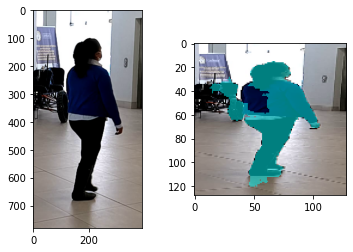

In [58]:
hog = cv2.HOGDescriptor() 
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

clip_path = '/home/israel/Downloads/OAK/j2/05.08.2021_12.42.19_id:carlos1_walk:nm/color_video.mp4'
clip_path = '/home/israel/Downloads/OAKD_8S/clips/120/004/nm/nm-06.avi'
# cap = cv2.VideoCapture('../data/videos/001-nm-01-090.avi')
# cap = cv2.VideoCapture('/home/israel/Downloads/CASIA/DatasetB-1/video/001-nm-02-090.avi')
cap = cv2.VideoCapture(clip_path)

# cap = cv2.VideoCapture('/home/israel/Downloads/3.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 70)
ret, frame = cap.read()
# frame = cv2.resize(frame, (0,0), fx=0.25, fy=0.25)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
regions, _ = hog.detectMultiScale(frame, winStride=(16, 16)) 
for (x, y, w, h) in regions:
    roi = frame[y:y+h, x:x+w]
    color = random_colors(2)
    roi_resized = cv2.resize(roi, (width, height), cv2.INTER_LINEAR)
    pred = inference(roi)
    out = apply_mask(roi_resized, pred, color[-1])
    plt.subplot(121); plt.imshow(roi); 
    plt.subplot(122); plt.imshow(out);
#     plt.show()
cap.release()

In [9]:
roi.shape

NameError: name 'roi' is not defined

In [45]:
def limit_bbox(x, y, w, h, width, height):
    offsets = [random.randint(0, w//2) for i in range(4)]
    x = x - offsets[0] if x - offsets[0] >=0 else 0
    y = y - offsets[1] if y - offsets[1] >=0 else 0
    w = w + offsets[2]+offsets[0] if w + offsets[2]+offsets[0] <=width else width
    h = h + offsets[3]+offsets[1] if h + offsets[3]+offsets[1] <=height else height
    return (x, y, w, h)

In [61]:
hog = cv2.HOGDescriptor() 
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# frame_height, frame_width,_ = frame.shape
# out_cap = cv2.VideoWriter('CASIA_dataset.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width//4,frame_height//4))


# cap = cv2.VideoCapture('../data/videos/001-nm-01-090.avi')
# cap = cv2.VideoCapture('/home/israel/Downloads/s1_ucb.mp4')
# cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture('/home/israel/Downloads/CASIA/DatasetB-1/video/033-nm-02-090.avi')
# clip_path = '/home/israel/Downloads/UCB/clips/090/002/cl/cl-01.avi'
cap = cv2.VideoCapture(clip_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 1)
fw = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)//4)
fh = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)//4)

roi = np.zeros((100,100))
color = random_colors(2)

cv2.namedWindow('roi', cv2.WINDOW_NORMAL)
nframe = 0
start = time.time()
fps = 30
regions = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        copied = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
#         copied = frame.copy()
        if nframe%1 == 0:
            new_regions, _ = hog.detectMultiScale(copied, winStride=(12, 12)) 
            if len(new_regions)>0:
                regions = new_regions
        for (x, y, w, h) in regions: 
#             x, y, w, h = limit_bbox(x, y, w, h, width, height)
            roi = copied[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi, (width, height), cv2.INTER_LINEAR)
            if nframe%1 == 0:
                roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
                pred = inference(roi_rgb)
#             pred = lite_inference(roi)
            out = apply_mask(roi_resized, pred, color[1])
            copied[y:y+h, x:x+w] = cv2.resize(out, (w, h), cv2.INTER_LINEAR)
            cv2.rectangle(copied, (x, y), (x + w, y + h), (0, 0, 255), 2) 
            
#         cv2.imshow('test', frame)
        
        cv2.putText(copied, "fps: {:.2f}".format(fps), (5, 20), cv2.FONT_ITALIC, 0.5, (255, 0, 0))
        cv2.imshow('roi', copied)
#         out_cap.write(copied)
        nframe +=1
        end = time.time()
        fps = nframe/(end - start)
    else:
        break
    if cv2.waitKey(1) == ord('q'):
        break
        
cap.release()
# out_cap.release()
cv2.destroyAllWindows()

0.028949975967407227
0.028241872787475586
0.027527332305908203
0.03393101692199707
0.029663562774658203
0.03543663024902344
0.02688312530517578
0.028244733810424805
0.026914119720458984
0.038742780685424805
0.026003599166870117
0.027356624603271484
0.027751445770263672
0.03324389457702637
0.02699875831604004
0.02780890464782715
0.02884840965270996
0.02833414077758789
0.027935266494750977
0.027979135513305664
0.02646183967590332
0.03325676918029785
0.029259681701660156
0.027234315872192383
0.029670238494873047
0.026648998260498047
0.028603076934814453
0.026688575744628906
0.02888035774230957
0.029159069061279297
0.028836727142333984
0.027741193771362305
0.028134822845458984
0.028953075408935547
0.0295562744140625
0.028017759323120117
0.03294038772583008
0.03571009635925293
0.028897523880004883
0.028673410415649414
0.027255773544311523
0.0289456844329834
0.0287020206451416
0.0280148983001709
0.029611587524414062
0.03535175323486328
0.02905893325805664
0.029896259307861328
0.0277881622314

In [62]:
cv2.destroyAllWindows()

In [50]:
width, height

(480.0, 270.0)